# Metagenomics classifier generalization

### Главная идея
Современные классификаторы полных геномов НИКОГДА не могут оценить реальное количество - не то что организма, а даже количества прочтений в метагеноме.

К тому же, их результаты не всегда сходятся. Что же делать?

--

**Voting + GLM**

- [Объединяем результаты различных аннотаторов в одну таблицу:](https://colab.research.google.com/drive/1fu-vQOSNFS2aapMPB-3x8XIRpAYlKvtg#scrollTo=l6UwkDBDWWDs)

- Накидываем сверху классификатор

- По полученным классификациям фитим реальный многомерный glm видов

## Библиотеки

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import re
import math

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

## Импорт

["Детский" пример](https://drive.google.com/file/d/1a3jHtgWYEKb_Gy6u9VOnAxyOW_KLgc0h/view?usp=drive_link)

[Искусственные данные для теста модели](https://drive.google.com/file/d/1RNaLFxGUzeEd72hSmRApFejeUqttYLAO/view?usp=sharing)

Данные для эвалюирования: в работе



In [ ]:
# !wget -O df.csv -r 'https://drive.usercontent.google.com/download?id=1a3jHtgWYEKb_Gy6u9VOnAxyOW_KLgc0h'
!wget -O df.csv -r 'https://drive.usercontent.google.com/download?id=1RMFoU2PndGIL5WcCCyesrK3mexnxGnSr'
!echo -e "\n\n####\n"
!head df.csv

will be placed in the single file you specified.

--2024-09-28 18:42:53--  https://drive.usercontent.google.com/download?id=1RMFoU2PndGIL5WcCCyesrK3mexnxGnSr
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.194.132, 2607:f8b0:4001:c10::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.194.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 525061 (513K) [application/octet-stream]
Saving to: ‘df.csv’

df.csv              100%[===================>] 512.75K  --.-KB/s    in 0.008s  

2024-09-28 18:42:55 (61.5 MB/s) - ‘df.csv’ saved [525061/525061]

FINISHED --2024-09-28 18:42:55--
Total wall clock time: 2.7s
Downloaded: 1 files, 513K in 0.008s (61.5 MB/s)


####

"ann1","ann2","ann3","ann4","ann5","ann6","ann7","length","true"
"id73","id90","id10","id12","id12","0","id85",134,"id12"
"0","0","0","id99","0","0","id75",150,"id75"
"0","0","id17","id49","id54","id17","id25",154,"id17"
"id11","0","0","id

In [ ]:
df = pd.read_table("df.csv", sep=",")
df.head()
df.tail()

id_and_len = {}
all_id = [i for i in df[df.columns[8]]]
all_len = [i for i in df[df.columns[7]]]

for i in range(len(all_id)):
  id_and_len[all_id[i]] = all_len[i]

## Clear data.frame to import for ML

In [ ]:
df_clear = df.copy()
if "seq" == df_clear.columns[0]:
  df_clear = df_clear.drop("seq", axis = 1)
df_clear.head()

,ann1,ann2,ann3,ann4,ann5,ann6,ann7,length,true
0,id73,id90,id10,id12,id12,0,id85,134,id12
1,0,0,0,id99,0,0,id75,150,id75
2,0,0,id17,id49,id54,id17,id25,154,id17
3,id11,0,0,id13,id12,id99,id48,115,id13
4,id88,0,0,id99,id12,0,id43,44,id99


In [ ]:
df_tree = df_clear.apply(LabelEncoder().fit_transform)
target = "true"
df_tree.head()

,ann1,ann2,ann3,ann4,ann5,ann6,ann7,length,true
0,72,91,2,4,5,0,85,99,4
1,0,0,0,99,0,0,74,115,73
2,0,0,10,44,51,10,19,119,9
3,4,0,0,5,5,100,44,80,5
4,88,0,0,99,5,0,39,9,99


In [ ]:
categorical_columns_subset = df.columns[1:4]
numerical_columns_subset = "length"

y = df_clear["true"]

X = df_clear.loc[:, [*categorical_columns_subset, numerical_columns_subset] ]
X[categorical_columns_subset] = X[categorical_columns_subset].astype("category")
X_NT=pd.get_dummies(X,columns=categorical_columns_subset,drop_first=False)
X_NT.head()

,length,ann2_0,ann2_id1,ann2_id10,ann2_id100,ann2_id11,ann2_id12,ann2_id13,ann2_id14,ann2_id15,...,ann4_id90,ann4_id91,ann4_id92,ann4_id93,ann4_id94,ann4_id95,ann4_id96,ann4_id97,ann4_id98,ann4_id99
0,134,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,150,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,154,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,115,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,44,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


## Desision tree

In [ ]:
X_T=df_tree.drop(target, axis = 1)
idx = list( range(0, len(X_T) ) )

X_T_train, X_T_test, y_train, y_test, idx_train, idx_test = model_selection.train_test_split(X_T, y, idx)

clfDTC=DecisionTreeClassifier(criterion="entropy")
clfDTC.fit(X_T_train,y_train)
y_pred=clfDTC.predict(X_T_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         id1       0.87      0.54      0.67        24
        id10       0.53      0.89      0.67         9
       id100       0.56      0.50      0.53        46
        id11       0.71      0.56      0.62        18
        id12       0.54      0.62      0.58        34
        id13       0.61      0.59      0.60        39
        id14       0.12      0.25      0.17         4
        id15       0.58      0.68      0.62        22
        id17       0.54      0.47      0.50        15
        id18       0.65      0.51      0.57        39
        id19       0.52      0.79      0.62        19
         id2       0.66      0.61      0.64        44
        id20       0.57      0.62      0.59        13
        id21       0.64      0.41      0.50        17
        id22       0.58      0.69      0.63        32
        id23       0.74      0.68      0.71        41
        id24       0.64      0.62      0.63        37
        id25       0.64    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [ ]:
df_GLM = df_clear.loc[idx_test, :].drop("length", axis = 1).astype("category")
df_GLM["pred"] = y_pred

In [ ]:
df_GLM.head()

,ann1,ann2,ann3,ann4,ann5,ann6,ann7,true,pred
7691,id50,0,id33,id50,id44,id50,id75,id50,id50
4535,id2,0,0,id22,id22,id22,id98,id22,id22
5844,0,0,id30,id63,id7,id7,id75,id7,id63
3418,0,0,id23,id40,id40,id40,id38,id40,id40
9442,0,0,0,id21,0,id21,id4,id21,id21


## GLM prepare

Задача: по полученным данным уточнить реальные количества. То есть для создания модели могут использоваться ТОЛЬКО предсказанные данные. Универсальность предсказания и саму модель можно проверять на разных `train_test_split`.

Алгоритм должен быть универсальным и принимать на вход любое количество строк и столбцов, и сам оптимизировать модели.

В `toy_example.csv`, очевидно, результат может быть достигнут простой пропорцией, и моделирование здесь не нужно. В остальных случаях требуется более сложная аппроксимация: за реальную численность одного таксона может отвечать численность многих таксонов с некоторыми вероятностями.

Построить минимум для toy_example, и разработать минимальный фит для искусственных данных. Этого вместе уже хватит, чтобы написать тезисы

In [ ]:
for i in df_GLM.copy().drop("true", axis = 1).columns:
  htm = pd.DataFrame([df_GLM.loc[j,i] == df_GLM.loc[j,"true"] for j in idx_test]).value_counts()

  tn = 0
  try:
    fn = pd.DataFrame([df_GLM.loc[j,i] == "0" for j in idx_test]).value_counts()[True]
  except:
    fn = 0

  tp = htm[True]
  fp = htm[False]-fn

  prec = tp/(fp+tp)
  rec = tp /(fn+tp)
  print(i)
  print("Precision:", round(prec,2))
  print("Recall:", round(rec,2))
  print("FN rate:", round(fn/len(df_GLM), 2))
  print("\n####\n")

ann1
Precision: 0.49
Recall: 0.52
FN rate: 0.31

####

ann2
Precision: 0.01
Recall: 0.0
FN rate: 0.89

####

ann3
Precision: 0.66
Recall: 0.66
FN rate: 0.26

####

ann4
Precision: 0.68
Recall: 1.0
FN rate: 0.0

####

ann5
Precision: 0.29
Recall: 0.34
FN rate: 0.36

####

ann6
Precision: 0.55
Recall: 0.56
FN rate: 0.3

####

ann7
Precision: 0.06
Recall: 0.52
FN rate: 0.05

####

pred
Precision: 0.54
Recall: 1.0
FN rate: 0.0

####



In [ ]:
df_taxid = pd.DataFrame()
for col in df_GLM.columns:
  df_taxid[col] = df_GLM[col].value_counts()


'''
df_taxid.insert(7, 'lenght', df[df.columns[7]])
for i in df_taxid.rows[::]:
  print(0)
df_taxid'''

df_taxid

# print(df[df.columns[7]][0])

,ann1,ann2,ann3,ann4,ann5,ann6,ann7,true,pred
ann1,,,,,,,,,
0,782,2221.0,642,NaN,892,745,124,NaN,NaN
id2,30,3.0,29,38.0,47,37,25,44.0,41.0
id46,29,7.0,18,33.0,13,24,19,35.0,33.0
id83,29,5.0,27,33.0,11,9,23,37.0,57.0
id74,28,2.0,27,29.0,15,18,23,37.0,40.0
...,...,...,...,...,...,...,...,...,...
id10,8,1.0,9,21.0,17,12,25,9.0,15.0
id65,7,4.0,8,8.0,12,9,14,1.0,NaN
id3,6,2.0,13,27.0,20,18,25,16.0,33.0


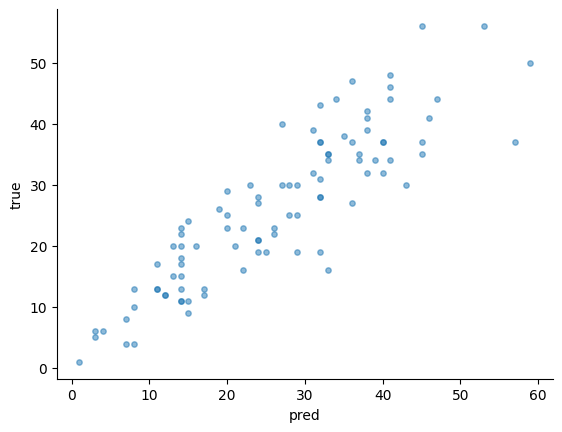

In [ ]:
df_taxid.plot(kind='scatter', x='pred', y='true', s=15, alpha=.5)
plt.gca().spines[['top', 'right',]].set_visible(False)

А дальше - наконец-то -
## GLM!

In [ ]:
curr = [] # массив со значениями pred, true, id, len
ind = 0
for i in df_taxid.values[::]:
  if math.isnan(i[-1]) or math.isnan(i[-2]): # избавляемся от NaN
    ind += 1
    continue
  curr.append([i[-1], i[-2], df_taxid.index[ind], id_and_len[df_taxid.index[ind]]])
  ind += 1


print(curr)

'''
print(curr)
X = np.array(curr)
# y = 0.90913227 * x_0 + 1 * x_1
y = np.dot(X, np.array([0.90913227, 1]))
reg = LinearRegression().fit(X, y) # регрессия
print(reg.coef_)'''

'''
print(np.corrcoef([i[0] for i in curr], [i[1] for i in curr])) # коэффициент корреляции
for i in range(len(curr)):
  curr[i][1] *= 100
print(curr)
print(np.corrcoef([i[0] for i in curr], [i[1] for i in curr])) # коэффициент корреляции с умножением на коэффициент'''


reg = linear_model.LinearRegression()
reg.fit([[i[0]] for i in curr], [i[1] for i in curr])
print(reg.coef_)
print(reg.intercept_)

mean_tg = sum([i[1] / i[0] for i in curr]) / len(curr) # средний тангенс точек
print(mean_tg)
MAE_tg = sum([abs(i[1] - mean_tg * i[0]) for i in curr]) / len(curr)
MAE_regression = sum([abs(i[1] - 0.9125844 * i[0] - 2.2451980133837424) for i in curr]) / len(curr)
print(MAE_tg, MAE_regression)

[[41.0, 44.0, 'id2', 183], [33.0, 35.0, 'id46', 180], [57.0, 37.0, 'id83', 189], [40.0, 37.0, 'id74', 89], [33.0, 34.0, 'id47', 220], [53.0, 56.0, 'id39', 152], [40.0, 37.0, 'id26', 82], [36.0, 47.0, 'id25', 68], [27.0, 40.0, 'id97', 128], [41.0, 34.0, 'id40', 192], [41.0, 48.0, 'id62', 64], [22.0, 23.0, 'id68', 142], [24.0, 28.0, 'id31', 51], [37.0, 35.0, 'id79', 71], [32.0, 37.0, 'id61', 125], [45.0, 56.0, 'id9', 83], [40.0, 32.0, 'id29', 121], [37.0, 34.0, 'id43', 159], [59.0, 50.0, 'id4', 143], [20.0, 29.0, 'id70', 126], [32.0, 43.0, 'id91', 103], [41.0, 46.0, 'id100', 116], [38.0, 42.0, 'id71', 183], [32.0, 37.0, 'id50', 163], [14.0, 20.0, 'id67', 114], [38.0, 41.0, 'id23', 172], [47.0, 44.0, 'id80', 47], [29.0, 30.0, 'id5', 173], [14.0, 17.0, 'id60', 90], [24.0, 27.0, 'id36', 131], [39.0, 34.0, 'id12', 59], [20.0, 25.0, 'id41', 38], [31.0, 39.0, 'id18', 196], [34.0, 44.0, 'id90', 138], [38.0, 39.0, 'id13', 171], [45.0, 35.0, 'id44', 109], [46.0, 41.0, 'id7', 37], [35.0, 38.0, 'id

Преобразование данных на основании регрессии

In [ ]:
d = {'id' : [i[2] for i in curr], 'len' : [i[3] for i in curr], 'true' : [i[1] for i in curr], 'pred' : [i[0] for i in curr], 'reg+pred' : [i[0] * mean_tg for i in curr]}
df_reg = pd.DataFrame(data=d)
df_reg

,id,len,true,pred,reg+pred
0,id2,183,44.0,41.0,43.081045
1,id46,180,35.0,33.0,34.674987
2,id83,189,37.0,57.0,59.893160
3,id74,89,37.0,40.0,42.030287
4,id47,220,34.0,33.0,34.674987
...,...,...,...,...,...
90,id14,146,4.0,8.0,8.406057
91,id38,181,13.0,8.0,8.406057
92,id10,49,9.0,15.0,15.761358
93,id3,127,16.0,33.0,34.674987


In [ ]:
'''print([(i[0], i[1]) for i in curr])
print([(i[0], i[1]) for i in curr if i[3] <= 104])
print([(i[0], i[1]) for i in curr if 104 < i[3] <= 154])
print([(i[0], i[1]) for i in curr if 154 < i[3]])

mean_tg_1 = sum([i[1] / i[0] for i in curr if i[3] <= 104]) / len([i for i in curr if i[3] <= 104]) # средний тангенс точек 1.012833671998631
print(mean_tg_1)
mean_tg_2 = sum([i[1] / i[0] for i in curr if 104 < i[3] <= 154]) / len([i for i in curr if 104 < i[3] <= 154]) # средний тангенс точек 1.102737781758341
print(mean_tg_2)
mean_tg_3 = sum([i[1] / i[0] for i in curr if 154 < i[3]]) / len([i for i in curr if 154 < i[3]]) # средний тангенс точек 1.1219641182898248
print(mean_tg_3)
'''


'print([(i[0], i[1]) for i in curr])\nprint([(i[0], i[1]) for i in curr if i[3] <= 104])\nprint([(i[0], i[1]) for i in curr if 104 < i[3] <= 154])\nprint([(i[0], i[1]) for i in curr if 154 < i[3]])\n\nmean_tg_1 = sum([i[1] / i[0] for i in curr if i[3] <= 104]) / len([i for i in curr if i[3] <= 104]) # средний тангенс точек 1.012833671998631\nprint(mean_tg_1)\nmean_tg_2 = sum([i[1] / i[0] for i in curr if 104 < i[3] <= 154]) / len([i for i in curr if 104 < i[3] <= 154]) # средний тангенс точек 1.102737781758341\nprint(mean_tg_2)\nmean_tg_3 = sum([i[1] / i[0] for i in curr if 154 < i[3]]) / len([i for i in curr if 154 < i[3]]) # средний тангенс точек 1.1219641182898248\nprint(mean_tg_3)\n'

подсчет R2

In [ ]:
print(r2_score([i[1] for i in curr], [i[0] for i in curr])) # R2 без регрессии
print(r2_score([i[1] for i in curr], [i[0] * 0.89008196 + 2.860159056910149 for i in curr])) # R2 и регрессия со свободным членом



0.7582521837490473
0.7787923492516637


регрессия с отделением коротких прочтений

In [ ]:
short_filter = 104
reg_short = linear_model.LinearRegression()
reg_short.fit([[i[0]] for i in curr if i[3] < short_filter], [i[1] for i in curr if i[3] < short_filter])
print(reg_short.coef_)
slope_short = float(reg_short.coef_[0])
print(reg_short.intercept_)
intercept_short = float(reg_short.intercept_)

reg_long = linear_model.LinearRegression()
reg_long.fit([[i[0]] for i in curr if i[3] >= short_filter], [i[1] for i in curr if i[3] >= short_filter])
print(reg_long.coef_)
slope_long = float(reg_long.coef_[0])
print(reg_long.intercept_)
intercept_long = float(reg_long.intercept_)

long_short_updated_pred = []
for i in curr:
  if i[3] <= 104:
    long_short_updated_pred.append((i[0] * 0.82229386 + 5.7881713108607755, i[1])) # i[0] - predicted value
  # elif 104 < i[3] <= 154:
    # updated_pred.append((i[0] * 1.102737781758341, i[1]))
  else:
    long_short_updated_pred.append((i[0] * 0.88626499 + 2.4476054829839278, i[1]))
print(r2_score([i[1] for i in long_short_updated_pred], [i[0] for i in long_short_updated_pred]))

[0.90118887]
2.999786431266454
[0.8356609]
4.008243911965906
0.777220901329265


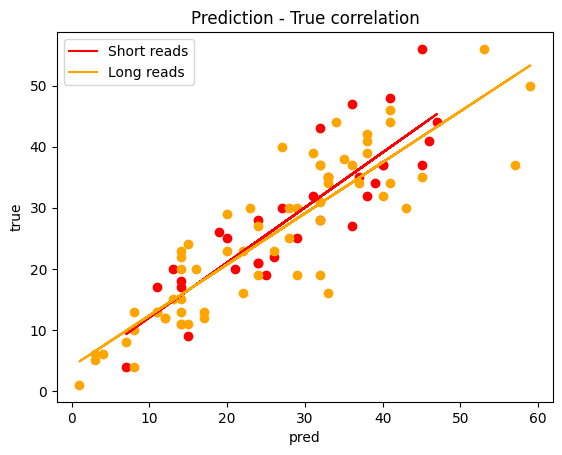

In [ ]:
x_short = np.array([i[0] for i in curr if i[3] < short_filter]) # График для коротких прочтений
y_short = np.array([i[1] for i in curr if i[3] < short_filter])
line_short = slope_short * x_short + intercept_short
plt.scatter(x_short, y_short, color='red')
plt.plot(x_short, line_short, color='red', linestyle='-', label='Short reads')


x_long = np.array([i[0] for i in curr if i[3] >= short_filter]) # График для длинных прочтений
y_long = np.array([i[1] for i in curr if i[3] >= short_filter])
line_long = slope_long * x_long + intercept_long
plt.scatter(x_long, y_long, color='orange')
plt.plot(x_long, line_long, color='orange', linestyle='-', label='Long reads')



plt.title('Prediction - True correlation')
plt.legend()
plt.xlabel("pred")
plt.ylabel("true")
plt.show()

# Bootstrap corrections

In [ ]:
def ML(x):
  pass

def regr(x):
  pass

def R2(x):
  pass

def in2out(table):
  #init
  df = pd.DataFrame(columns = ["id", "R2"])

  # table ->
  start_R2 = []
  # true class
  # class by classificator
  for col in table.columns:
    TP = 12
    F = 2
    R2 = TP/F

    df.loc[col, :] = [col, R2]

  # ML
  ML_data = ML(table)
  df.loc["ML", :] = ["ML", R2]

  # GLM correction
  REGR_data = regr(ML_data)
  df.loc["fin", :] = ["ML", R2]

  return df

res = pd.DataFrame()
for _ in range(100):
  res.iloc[_:] = in2out(table)

In [ ]:
import plotnine as pn



# ---- To implement

## HGBR

In [ ]:
hist_native = HistGradientBoostingRegressor()
hist_native.fit(X_NT,y)

In [ ]:
scoring = "neg_mean_absolute_percentage_error"
n_cv_folds = 3

HGBR_result = cross_validate(hist_native, X, y, cv=n_cv_folds, scoring=scoring)